# Sinusoidal Postional Encoding (concatenate in axis 1)

### step1: Generate positional encoding using pe = sin(x) where x = [1,2,3,...,n]/n <br> step2: concatenate pe to original vector at axis 1.

## Libraries

In [1]:
from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle
import Models

# Path

In [2]:
print(os.getcwd())

C:\Users\Administrator-1\Experiment_2\cnn_transformer


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

## Data preparation

In [6]:
data = pickle.load(open(training_data_kok14_galfa, 'rb'))
# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']
print(X_train.shape)
print(Y_train.shape)

(38781, 414)
(38781, 2)


In [7]:
validation_size = 6000
x_train = X_train[0:X_train.shape[0]-validation_size, :]
x_val = X_train[X_train.shape[0]-validation_size:, :]
y_train = Y_train[0:X_train.shape[0]-validation_size, :]
y_val = Y_train[X_train.shape[0]-validation_size:, :]

In [8]:
print(f'x_train = {x_train.shape}, y_train = {y_train.shape}')
print(f'x_val = {x_val.shape}, y_val = {y_val.shape}')
print(f'X_test = {X_test.shape}, Y_test = {Y_test.shape}')

x_train = (32781, 414), y_train = (32781, 2)
x_val = (6000, 414), y_val = (6000, 2)
X_test = (58, 414), Y_test = (58, 2)


## Split train, validation and testing set from X_train and Y_train with percentage of 60%, 20%, 20%.

In [9]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(X_train,
                                                    Y_train,
                                                    test_size=0.2,
                                                    shuffle = True, 
                                                    random_state = 8)

# Use the same function above for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state= 8) # 0.25 x 0.8 = 0.2

In [10]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

x_train= (23268, 414) , y_train= (23268, 2)
x_val= (7756, 414) , y_val= (7756, 2)
x_test= (7757, 414) , y_test= (7757, 2)


## Plot a few training samples

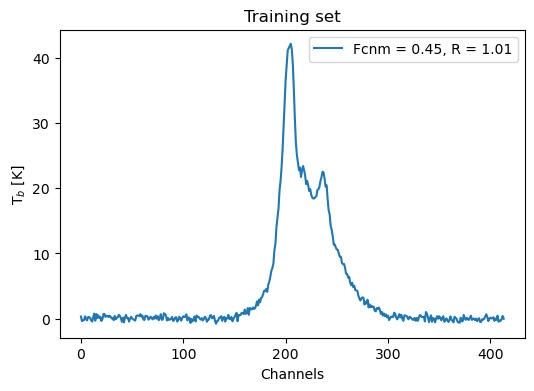

In [15]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(x_train[0, :], label=f'Fcnm = {round(Y_train[20000,0], 2)}, R = {round(Y_train[0,1], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

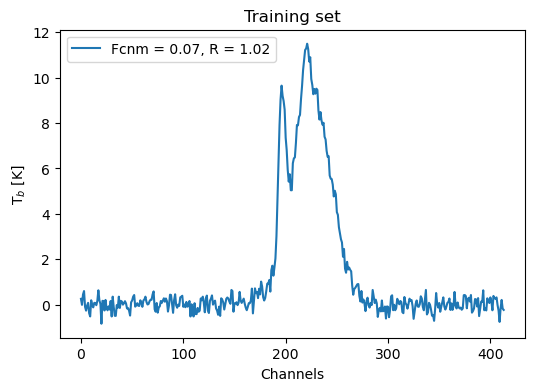

In [16]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(x_train[1000, :], label=f'Fcnm = {round(Y_train[10000,0], 2)}, R = {round(Y_train[10000,1], 2)}')

plt.title('Training set')
plt.xlabel('Channels')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

## Data loader

In [11]:
import data_loader
# initialize dataset
dataset_train = data_loader.spectra_loader(x_train, 
                                           y_train,transform=data_loader.ToTensor(), 
                                           target_transform=data_loader.ToTensor(), 
                                           pe='sin_concate')

dataset_val = data_loader.spectra_loader(x_val,
                                         y_val,
                                         transform=data_loader.ToTensor(),
                                         target_transform=data_loader.ToTensor()
                                         ,pe='sin_concate')

dataset_test = data_loader.spectra_loader(x_test, 
                                          y_test,
                                          transform=data_loader.ToTensor(), 
                                          target_transform=data_loader.ToTensor(),
                                          pe='sin_concate')

In [12]:
# initialize data loader
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle =True)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_val, batch_size = batch_size, shuffle =False)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle =False)

In [13]:
# test data loader
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 1, 2, 414])
torch.Size([20, 2])


## Model Training and Evaluation 

In [14]:
# train 
def train(epoch):
    """
    Train the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.

    Returns
    -------
    train_loss/total: The mean MSE in an epoch.     
    """
    model.train()
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward
        outputs = model(inputs)
        loss = loss_function(outputs, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
    print("total loss=",train_loss)
    return train_loss/total

In [15]:
def validation(epoch):
    """
    validate the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.

    Returns
    -------
    error: The mean MSE in validation set. 
        
    """
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    # Save checkpoint.
    error =  test_loss / total
    print(f"validation MSE in epoch {epoch}= ", error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/s8_sinusoidal_concatenate.pth')
        best_err = error
    return error

In [16]:
def test(epoch):
    """
    test the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.
    Returns
    -------
    error: The mean MSE in test set. 
    """
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        #print(f'Test performance in epoch {epoch}: avg_error = {test_loss/total}')
        return test_loss/total

## Start 10 trail Training

In [23]:
# define number of trails, number of epoch and learning rate
num_trial = 10
num_epoch = 80
learning_rate = 0.005
# the savier of best validation performance and coresponding testing performance.
vali = []
testing = []
# saver for each trials
train_trails = []
validate_trails =[]
test_trails = []

In [24]:
def trail(num_epoch):
    global vali
    global testing
    global scheduler
    global model
    global lr
    #define savor
    global train_trails
    global validate_trails
    global test_trails
    for epoch in range(num_epoch):
        train_err = train(epoch)
        vali_err = validation(epoch)
        scheduler.step()
        test_err = test(epoch)
        # save data
        train_trails.append(train_err)
        validate_trails.append(vali_err)
        test_trails.append(test_err)
    # final test
    validation_error,test_error = validate_model()
    print("test err=",test_error)
    vali.append(validation_error)
    testing.append(test_error)

In [19]:
def validate_model():
    global model
    model = Models.cnn_transformer(in_channels=1, 
                                   input_row =2, 
                                   input_column=414,
                                   pe=False)
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    checkpoint = torch.load('./checkpoint/s8_sinusoidal_concatenate.pth',
                            map_location=torch.device('cuda:0'))
    model.load_state_dict(checkpoint['net'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    validation_error = validation(epoch)
    test_error = test(epoch)
    return validation_error, test_error

In [26]:
# start 10 trails.
for i in range (0, num_trial):
    print(f'start the {i}th trial:')
    # model initialization
    lr=learning_rate
    model = Models.cnn_transformer(in_channels=1, 
                                   input_row =2, 
                                   input_column=414,
                                   pe=False)
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    optimizer = torch.optim.SGD(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                     milestones = [65], 
                                                     gamma=0.1, last_epoch=-1, 
                                                     verbose=False)
    device = torch.device('cuda:0')
    model.to(device)
    trail(num_epoch)

start the 0th trial:
total loss= 280.5912888729945
validation MSE in epoch 0=  0.00781881317144232
best_err: 0.00781881317144232 Saving..
total loss= 201.96416396507993
validation MSE in epoch 1=  0.0072324910022997044
best_err: 0.0072324910022997044 Saving..
total loss= 191.45665115583688
validation MSE in epoch 2=  0.006974847219997749
best_err: 0.006974847219997749 Saving..
total loss= 180.09513801150024
validation MSE in epoch 3=  0.006765393782519918
best_err: 0.006765393782519918 Saving..
total loss= 164.43620326789096
validation MSE in epoch 4=  0.005700982972993235
best_err: 0.005700982972993235 Saving..
total loss= 152.19230131059885
validation MSE in epoch 5=  0.005334082860510427
best_err: 0.005334082860510427 Saving..
total loss= 146.4770726535935
validation MSE in epoch 6=  0.006766400804217591
total loss= 142.1363168475218
validation MSE in epoch 7=  0.006673231215877607
total loss= 133.90706325508654
validation MSE in epoch 8=  0.08044596643308624
total loss= 130.4099378

# Results.

## 1. plot the training and validation and testing chart

In [17]:
def plott(x, ti):
    """
    A method to plot training process.
    ...
    Parameters
    ----------
    x : nparray.
        the data to plot with shape of (800,1).
    ti : str
        The title of the plot.
    """
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

In [18]:
def plott_20(x, ti):
    """
    A method to plot training process in the last 20 epoch.
    ...
    Parameters
    ----------
    x : nparray.
        the data to plot with shape of (800, ).
    ti : str
        The title of the plot.
    """
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index+59: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails(last 20 epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()

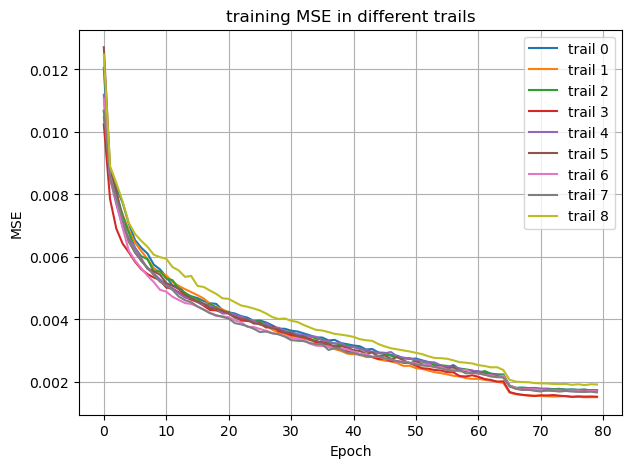

In [29]:
# training 
x = np.array(train_trails)
plott(x, "training")

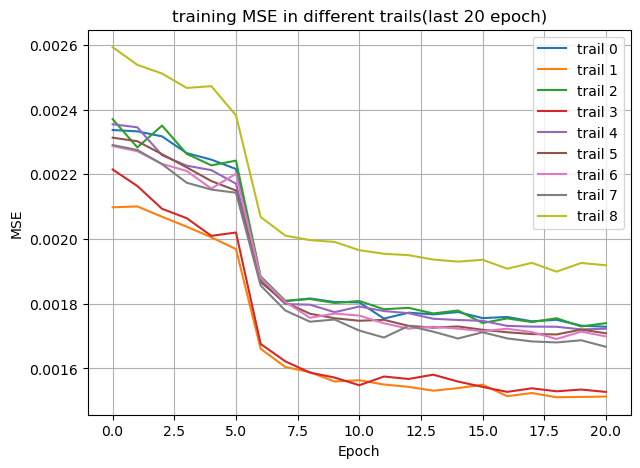

In [30]:
# training 
x = np.array(train_trails)
plott_20(x, "training")

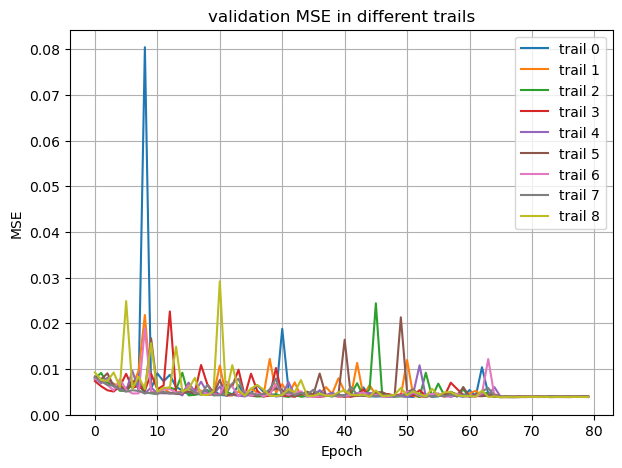

In [31]:
# validation
x = np.array(validate_trails)
plott(x, "validation")

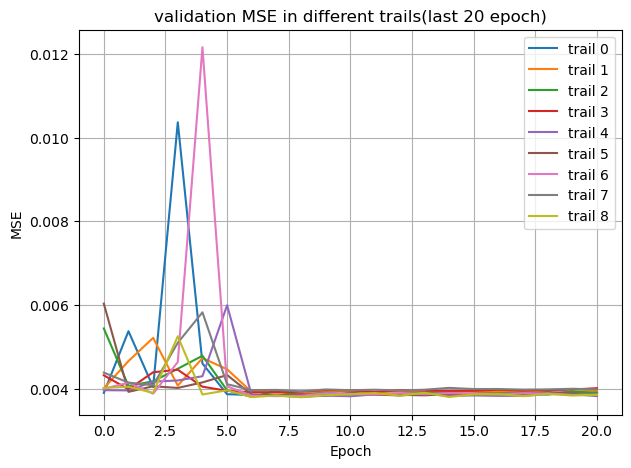

In [32]:
# validation
x = np.array(validate_trails)
plott_20(x, "validation")

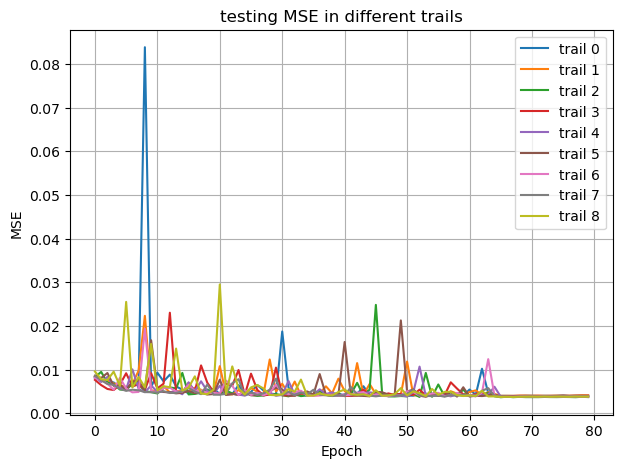

In [33]:
# testing 
x = np.array(test_trails)
plott(x, "testing")

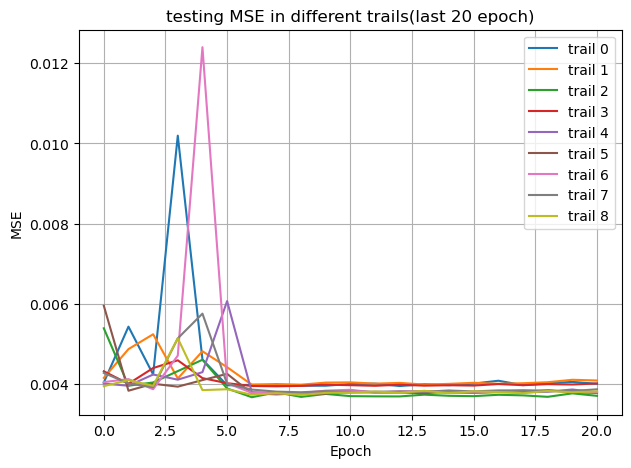

In [34]:
# testng
x =  np.array(test_trails)
plott_20(x, "testing")

## 2. plot the best velidation MSE and testing MSE

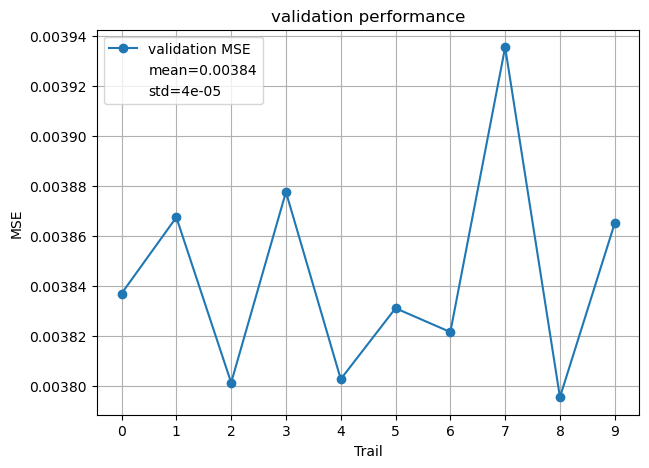

validation mean= 0.0038433538383899784
validation std= 4.136116593571861e-05


In [35]:
x = vali
plt.figure(figsize=(7,5))
plt.title('validation performance')
plt.plot(x, label='validation MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),5)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),5)}")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("validation mean=",np.mean(x))
print("validation std=",np.std(x))

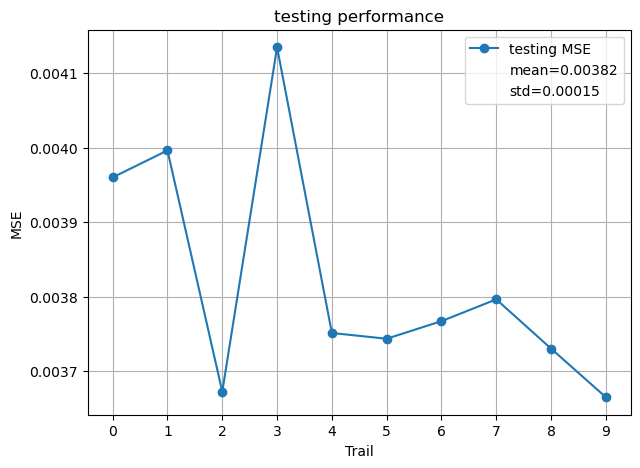

testing mean= 0.003821913670540825
testing std= 0.00014740046696620854


In [36]:
x = testing
plt.figure(figsize=(7,5))
plt.title('testing performance')
plt.plot(x, label='testing MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),5)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),5)}")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("testing mean=",np.mean(x))
print("testing std=",np.std(x))

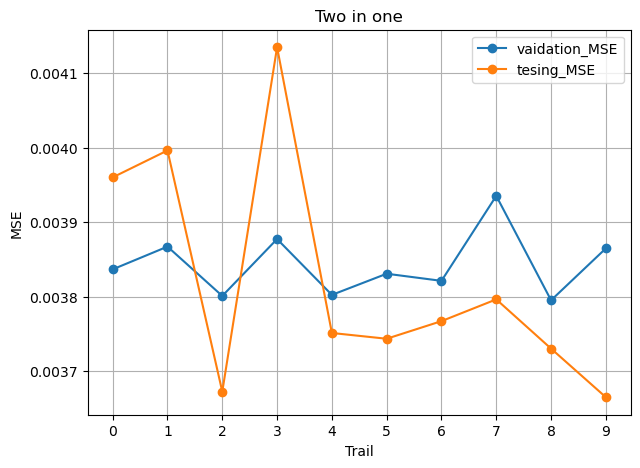

In [37]:
x1 = vali
x2 = testing
plt.figure(figsize=(7,5))
plt.title('Two in one')
plt.plot(x1, label='vaidation_MSE',marker='o')
plt.plot(x2, label='tesing_MSE',marker='o')
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()

## Save CSV

In [38]:
x1 = np.array(vali).reshape(1, -1)
x2 = np.array(testing).reshape(1, -1)
two = np.vstack((x1,x2))
df = pd.DataFrame(two).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\s8_sin_concatenate_ct.csv")

In [39]:
# save data 
x1 = np.array(train_trails).reshape(1, -1)
x2 = np.array(validate_trails).reshape(1, -1)
x3 = np.array(test_trails).reshape(1, -1)
three = np.vstack((x1,x2,x3))
df = pd.DataFrame(three).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\s8_sin_concatenate_process_ct.csv")